<a href="https://colab.research.google.com/github/hsinyang0816/ML2021-Colab-Code/blob/master/HW14_lifelong_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LifeLong Machine Learning
### TA's Slide
[Slide](https://docs.google.com/presentation/d/13JmcOZ9i_m5xJbRBKNMAKE1fIzGhyaeLck3frY0B2xY/edit?usp=sharing)

### Definition
The detailed explanations and definitions of LifeLong Learning please refer to [LifeLong learning](https://youtu.be/7qT5P9KJnWo) 


### Methods
Someone proposed a survey paper for LifeLong Learning at the end of 2019 to distinguish 2016-2019 LigeLong Learning methods into three families.

We can distinguish LifeLong Learning methods into three families, based on how task
specific information is stored and used throughout the sequential learning process:
* Replay-based methods
* Regularization-based methods
* Parameter isolation methods

<img src="https://i.ibb.co/VDFJkWG/2019-12-29-17-25.png" width="100%">

In this assignment, we have to go through EWC, MAS, SI, Remanian Walk, SCP Methods in the prior-focused methods of the regularization-based methods. 

Source: [Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf)

Please feel free to mail us if you have any questions.

ntu-ml-2020spring-ta@googlegroups.com



### Table of Content
- Utils
- Visualization
- Methods

### Utility
We utilize permuted MNIST as our training dataset.

So, first we utilize 5 different permutations to generate 10 different permuted MNIST as different task.

 #### - Pemutation

In [ ]:
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
import os
import torch.nn.functional as F
from torchvision import datasets, transforms

# Permute MNIST to generate 10 tasks

def _permutate_image_pixels(image, permutation):
    if permutation is None:
        return image

    c, h, w = image.size()
    image = image.view(-1, c)
    image = image[permutation, :]
    image.view(c, h, w)
    return image

def get_transform(permutation=None, normalize=True):
  if normalize == True:
    transform = transforms.Compose([transforms.ToTensor(),
                                    Pad(28),
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                    transforms.Lambda(lambda x: _permutate_image_pixels(x, permutation)),
    ])
  else:
    transform = transforms.Compose([transforms.ToTensor(),
                                    Pad(28),
                                    transforms.Lambda(lambda x: _permutate_image_pixels(x, permutation)),
    ])
  return transform

class Pad(object):
  def __init__(self, size, fill=0, padding_mode='constant'):
    self.size = size
    self.fill = fill
    self.padding_mode = padding_mode
    
  def __call__(self, img):
    # If the H and W of img is not equal to desired size,
    # then pad the channel of img to desired size.
    img_size = img.size()[1]
    assert ((self.size - img_size) % 2 == 0)
    padding = (self.size - img_size) // 2
    padding = (padding, padding, padding, padding)
    return F.pad(img, padding, self.padding_mode, self.fill)

class Data():
  def __init__(self, path, train=True, permutation=None, normalize=True):

    transform = get_transform(permutation, normalize)
    self.dataset = datasets.MNIST(root = os.path.join(path, "MNIST"),
                                        transform=transform,
                                        train = train,
                                        download = True)

#### - Dataloader and Argument
- Training Arguments
- Setup 5 different Permutation
- 5 Train DataLoader
- 5 Test DataLoader 


In [ ]:
### Main Process

import argparse
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
from tqdm import trange

class Args:
  task_number = 5
  epochs_per_task = 10
  lr = 1.0e-4
  batch_size = 128
  test_size=8192
  random_seed=0

args=Args()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# generate permutations for the tasks.
np.random.seed(args.random_seed)

#generate permuted MNIST data from 10 different permutation.
permutations = [
    np.random.permutation(784) if index !=0 else np.arange(784) for index in range(args.task_number) ]

# prepare permuted mnist datasets.
train_datasets = [
    Data('data', permutation=permutations[index]) for index in range(len(permutations))
]
train_dataloaders = [
    DataLoader(data.dataset, batch_size=args.batch_size, shuffle=True) for data in train_datasets
]


test_datasets = [
    Data('data',train=False, permutation=permutations[index]) for index in range(len(permutations))
]
test_dataloaders = [
    DataLoader(data.dataset, batch_size=args.test_size, shuffle=True) for data in test_datasets
]



Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw




Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw




Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw




Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### - Model
To fair comparison, 

We fix our model architecture to do this homework. 

The model architecture consist 4 layers fully-connected network.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
  """
  Model architecture 
  784 (input) → 1024 → 512 → 256 → 10
  """
  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = x.view(-1, 1*28*28)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    return x

example = Model()
print(example)


Model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


#### - Train
This is our function of training process.

It can generally applied in different regularization-based lifelong learning algorithm in this homework.

In [ ]:
import torch
import torch.nn as nn
import tqdm
import numpy as np
from tqdm import trange

def train(model, optimizer, dataloader, epochs_per_task, lll_object, lll_lambda, test_dataloaders, evaluate, device, log_step=1):
    model.train()
    model.zero_grad()
    objective = nn.CrossEntropyLoss()
    acc_per_epoch = []
    loss = 1.0
    bar = tqdm.auto.trange(epochs_per_task, leave=False, desc=f"Epoch 1, Loss: {loss:.7f}")
    for epoch in bar:
        for imgs, labels in tqdm.auto.tqdm(dataloader, leave=False):            
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = objective(outputs, labels)
            total_loss = loss
            lll_loss = lll_object.penalty(model)
            total_loss += lll_lambda * lll_loss 
            lll_object.update(model)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            loss = total_loss.item()
            bar.set_description_str(desc=f"Epoch {epoch+1:2}, Loss: {loss:.7f}", refresh=True)
        acc_average  = []
        for test_dataloader in test_dataloaders: 
            acc_test = evaluate(model, test_dataloader, device)
            acc_average.append(acc_test)
        average=np.mean(np.array(acc_average))
        acc_per_epoch.append(average*100.0)
        bar.set_description_str(desc=f"Epoch {epoch+2:2}, Loss: {loss:.7f}", refresh=True)
                
    return model, optimizer, acc_per_epoch

#### - Evaluate
This is our function of evaluation process.

It can generally applied in different regularization-based lifelong learning algorithm in this homework.

In [ ]:
import torch
import torch.nn as nn


def evaluate(model, test_dataloader, device):
    model.eval()
    correct_cnt = 0
    total = 0
    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, pred_label = torch.max(outputs.data, 1)

        correct_cnt += (pred_label == labels.data).sum().item()
        total += torch.ones_like(labels.data).sum().item()
    return correct_cnt / total

#### - Evaluation Metric
We utilize **Average Accuracy** as our evaluation metric, 

which average the accuracy from the all previous and current test set to measure the performance of lifelong learning . 

### Visualization


#### - Permuted MNIST dataset

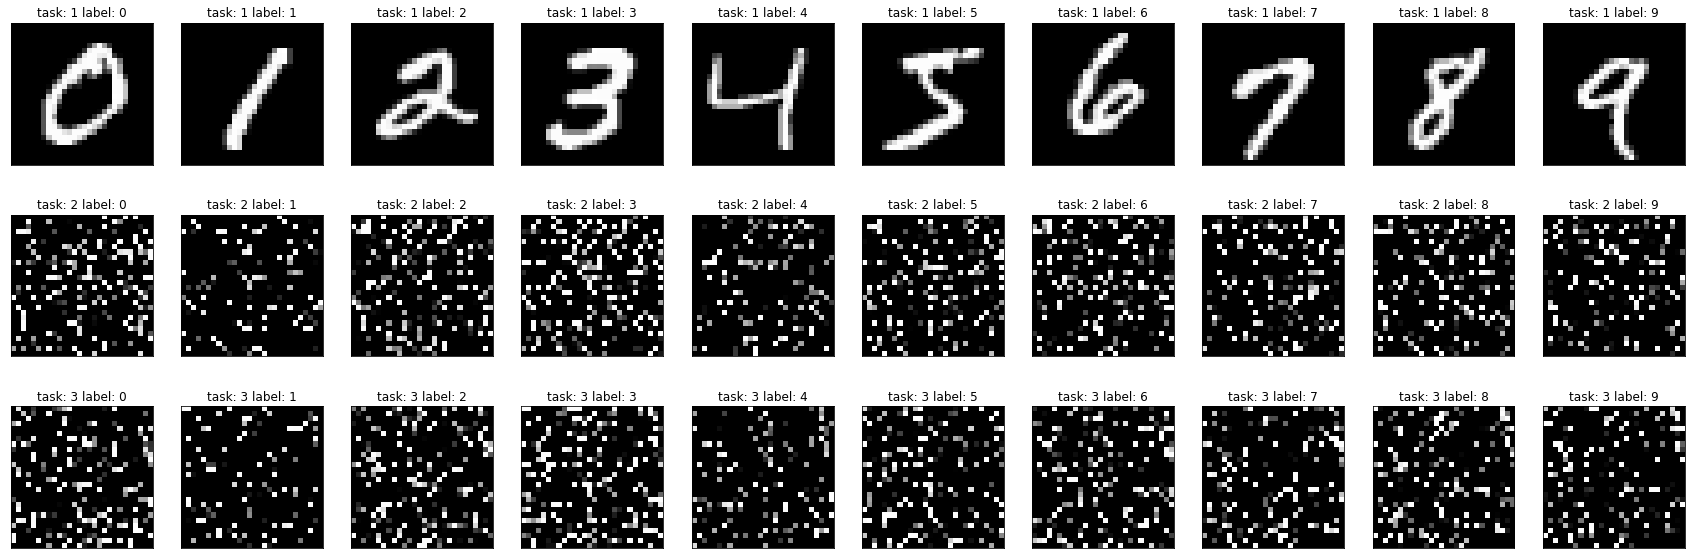

In [ ]:
### Visualize label 0-9 1 sample MNIST picture in first 3 task.

sample = [
    Data('data', permutation=permutations[index], normalize=False) for index in range(len(permutations))
]
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
for task in range(3):
  labels = [list(sample[task].dataset.targets).index(l) for l in range(10)]
  for idx, label in enumerate(labels):
    plt.subplot(3, 10, (task)*10 + idx + 1)
    curr_img = np.reshape(sample[task].dataset[label][0], (28, 28))
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'), fignum=False)
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.title("task: " + str(task+1) + " " + "label: " + str(idx), y=1)



### Methods
- Baseline
- EWC
- SI
- MAS
- RWalk
-SCP

#### - Baseline
The baseline class will do nothing in regularization term.

In [ ]:
# Baseline 
import torch
import torch.nn as nn


class baseline(object):
    """
    baseline technique: do nothing in regularization term [initialize and all weight is zero]
    """
    def __init__(self, model, dataloaders, device):
    
        self.model = model
        self.dataloaders = dataloaders
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} #extract all parameters in models
        self.p_old = {} # store current parameters
        self._precision_matrices = self._calculate_importance() # generate weight matrix 

        for n, p in self.params.items():
            self.p_old[n] = p.clone().detach() # keep the old parameter in self.p_old
  
    def _calculate_importance(self):
        precision_matrices = {}
        for n, p in self.params.items(): # initialize weight matrix（fill zero）
            precision_matrices[n] = p.clone().detach().fill_(0)

        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
            loss += _loss.sum()
        return loss
    
    def update(self, model):
        # do nothing
        return 


Main process for baseline

In [ ]:
# Baseline
print("RUN BASELINE")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# initialize lifelong learning object (baseline class) without adding any regularization term.
lll_object=baseline(model=model, dataloaders=[None],device=device)
lll_lambda=0.0
baseline_acc= []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")

# iterate training on each task continually.
for train_indexes in task_bar:
    # Train each task
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])

    # get model weight to baseline class and do nothing!
    lll_object=baseline(model=model, dataloaders=test_dataloaders[:train_indexes],device=device)

    # new a optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # Collect average accuracy in each epoch
    baseline_acc.extend(acc_list)
    
    # display the information of the next task.
    task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch! 
print(baseline_acc)
print("==================================================================================================")


RUN BASELINE



[94.19999999999999, 95.83, 96.82, 97.31, 97.64, 97.71, 97.66, 97.96000000000001, 97.48, 97.84, 96.0, 96.55, 96.72, 96.95499999999998, 96.71, 96.76, 96.26, 96.795, 96.42999999999999, 96.30000000000001, 95.11666666666666, 94.81, 94.39666666666668, 94.34666666666666, 93.85333333333334, 93.68666666666667, 93.02666666666667, 93.12333333333332, 92.73666666666665, 92.16333333333333, 91.21, 90.5775, 89.1675, 88.62249999999999, 87.6025, 86.485, 87.3775, 86.285, 85.925, 85.2075, 85.26, 84.108, 84.16799999999999, 83.65400000000001, 84.458, 84.136, 82.85799999999999, 82.68799999999999, 83.48400000000001, 82.39000000000001]


#### - EWC

Elastic Weight Consolidation

The ewc class applied EWC algorithm to calculate regularization term.
The central concept is included in Prof.Hung-yi's lectures. Here we will focus on the algorithm of EWC. 

In this assignment, we want to let our model learn 10 tasks successively.
Here we show a simple example that we let the model learn 2 tasks(task A, task B) successively.

In EWC algorithm, the definition of loss function is shown below:
 $$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} F_i (\theta_{i} - \theta_{A,i}^{*})^2  $$
  
Assume we have a neural network with more than two parameters.

$F_i$ correspond to the $i^{th}$ guard in Prof. Hung-yi's lecture. Please do not modify this parameters, because it's important to task A.

The definition of $F$ is shown below.
$$ F = [ \nabla \log(p(y_n | x_n, \theta_{A}^{*}) \nabla \log(p(y_n | x_n, \theta_{A}^{*})^T ] $$ 

We only take the diagonal value of matrix to approximate each parameters' $F_i$.

The detail infromation and derivation are shown in 2.4.1 and 2.4 of [Continual Learning in Neural
Networks](https://arxiv.org/pdf/1910.02718.pdf)

For You Information: [Elastic Weight Consolidation](https://arxiv.org/pdf/1612.00796.pdf)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ewc(object):
    """
    @article{kirkpatrick2017overcoming,
        title={Overcoming catastrophic forgetting in neural networks},
        author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
        journal={Proceedings of the national academy of sciences},
        year={2017},
        url={https://arxiv.org/abs/1612.00796}
    }
  """
    def __init__(self, model, dataloaders, device):
    
        self.model = model
        self.dataloaders = dataloaders
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} # extract all parameters in models
        self.p_old = {} # initialize parameters
        self._precision_matrices = self._calculate_importance() # generate Fisher (F) matrix for EWC 

        for n, p in self.params.items():
            self.p_old[n] = p.clone().detach() # keep the old parameter in self.p_old
  
    def _calculate_importance(self):
        precision_matrices = {}
        for n, p in self.params.items(): 
            # initialize Fisher (F) matrix（all fill zero）
            precision_matrices[n] = p.clone().detach().fill_(0)

        self.model.eval()
        if self.dataloaders[0] is not None:
            dataloader_num=len(self.dataloaders)
            number_data = sum([len(loader) for loader in self.dataloaders])
            for dataloader in self.dataloaders:
                for data in dataloader:
                    self.model.zero_grad()
                    # get image data
                    input = data[0].to(self.device)
                    # image data forward model
                    output = self.model(input)
                    # Simply use groud truth label of dataset.  
                    label = data[1].to(self.device)
                    # print(output.shape, label.shape)
                    
                    ############################################################################
                    #####                     generate Fisher(F) matrix for EWC            #####
                    ############################################################################    
                    loss = F.nll_loss(F.log_softmax(output, dim=1), label)             
                    loss.backward()                                                    
                    ############################################################################

                    for n, p in self.model.named_parameters():
                        # get the gradient of each parameter and square it, then average it in all validation set.                          
                        precision_matrices[n].data += p.grad.data ** 2 / number_data   
                                                                            
            precision_matrices = {n: p for n, p in precision_matrices.items()}

        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            # generate the final regularization term by the ewc weight (self._precision_matrices[n]) and the square of weight difference ((p - self.p_old[n]) ** 2).  
            _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
            loss += _loss.sum()
        return loss
    
    def update(self, model):
        # do nothing
        return 


Main process for EWC 

In [ ]:
#EWC
print("RUN EWC")
model = Model()
model = model.to(device)
# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# initialize lifelong learning object for EWC
lll_object=ewc(model=model, dataloaders=[None],device=device)

# setup the coefficient value of regularization term.
lll_lambda=100
ewc_acc= []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")

# iterate training on each task continually.
for train_indexes in task_bar:
    # Train Each Task
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
    
    # get model weight and calculate guidance for each weight
    lll_object=ewc(model=model, dataloaders=test_dataloaders[:train_indexes+1],device=device)

    # new a Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    # collect average accuracy in each epoch
    ewc_acc.extend(acc_list)

    # Update tqdm displayer
    task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(ewc_acc)
print("==================================================================================================")



RUN EWC



[94.11, 96.12, 96.7, 97.32, 97.64, 97.86, 98.08, 97.77, 97.28, 98.11999999999999, 96.32499999999999, 96.71000000000001, 96.89, 96.855, 96.78, 96.83999999999999, 96.53, 96.28999999999999, 96.435, 96.72, 95.25333333333333, 94.79, 94.01666666666667, 94.04666666666665, 93.6, 94.14333333333333, 93.28666666666666, 93.45333333333335, 93.46, 93.61666666666667, 92.9175, 91.74, 91.58, 91.6525, 91.985, 91.2775, 91.09249999999999, 91.725, 91.50500000000001, 90.9225, 89.738, 90.208, 90.274, 90.194, 89.984, 90.35, 90.63799999999999, 90.23400000000001, 90.35600000000001, 91.09400000000001]


#### - MAS
Memory Aware Synapses

The mas class applied MAS algorithm to calculate regularization term.

The concept of MAS is similar to EWC, the only difference is the calculation of the important weight. 
The details are mentioned in following blocks.

MAS:

In MAS, the Loss function is shown below, the model learn task A before it learned task B.

$$\mathcal{L}_B = \mathcal{L}(\theta) + \sum_{i} \frac{\lambda}{2} \Omega_i (\theta_{i} - \theta_{A,i}^{*})^2$$

Compare with EWC, the $F_i$ in the loss function is replaced with $\Omega_i$ in the following function.

$$\Omega_i = || \frac{\partial \ell_2^2(M(x_k; \theta))}{\partial \theta_i} || $$ 

$x_k$ is the sample data of the previous task. So the $\Omega$ is obtained gradients of the squared L2-norm of the learned network output.

The methods that proposed from paper is the local version by taking squared L2-norm outputs from the each layers of the model.

Here we only implmented the global version by taking outputs from the last layer of the model. 


For Your Information: 
[Memory Aware Synapses](https://arxiv.org/pdf/1711.09601.pdf)
 



In [ ]:
class mas(object):
    """
    @article{aljundi2017memory,
      title={Memory Aware Synapses: Learning what (not) to forget},
      author={Aljundi, Rahaf and Babiloni, Francesca and Elhoseiny, Mohamed and Rohrbach, Marcus and Tuytelaars, Tinne},
      booktitle={ECCV},
      year={2018},
      url={https://eccv2018.org/openaccess/content_ECCV_2018/papers/Rahaf_Aljundi_Memory_Aware_Synapses_ECCV_2018_paper.pdf}
    }
    """
    def __init__(self, model: nn.Module, dataloaders: list, device):
        self.model = model 
        self.dataloaders = dataloaders
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} #extract all parameters in models
        self.p_old = {} # initialize parameters
        self.device = device
        self._precision_matrices = self.calculate_importance() # generate Omega(Ω) matrix for MAS
    
        for n, p in self.params.items():
            self.p_old[n] = p.clone().detach() # keep the old parameter in self.p_old
    
    def calculate_importance(self):
        precision_matrices = {}
        for n, p in self.params.items():
            precision_matrices[n] = p.clone().detach().fill_(0) # initialize Omega(Ω) matrix（all filled zero）

        self.model.eval()
        if self.dataloaders[0] is not None:
            dataloader_num = len(self.dataloaders)
            num_data = sum([len(loader) for loader in self.dataloaders])
            for dataloader in self.dataloaders:
                for data in dataloader:
                    self.model.zero_grad()
                    output = self.model(data[0].to(self.device))

                    ###########################################################################################################################################
                    #####  TODO BLOCK: generate Omega(Ω) matrix for MAS. (Hint: square of l2 norm of output vector, then backward and take its gradients  #####
                    ###########################################################################################################################################
                    output.pow_(2)                                                   
                    loss = torch.sum(output,dim=1)                                   
                    loss = loss.mean()   
                    loss.backward() 
                    ###########################################################################################################################################                          
                                            
                    for n, p in self.model.named_parameters():                      
                        precision_matrices[n].data += p.grad.abs() / num_data ## difference with EWC      
                        
        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self.p_old[n]) ** 2
            loss += _loss.sum()
        return loss
    
    def update(self, model):
        # do nothing
        return 

Main process for MAS

In [ ]:
    # MAS
    print("RUN MAS")
    model = Model()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    lll_object=mas(model=model, dataloaders=[None],device=device)
    lll_lambda=0.1
    mas_acc= []
    task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
    for train_indexes in task_bar:
        # Train Each Task
        model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
        
        # get model weight and calculate guidance for each weight
        lll_object=mas(model=model, dataloaders=test_dataloaders[:train_indexes+1],device=device)

        # New a Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

        # Collect average accuracy in each epoch
        mas_acc.extend(acc_list)
        task_bar.set_description_str(f"Task  {train_indexes+2:2}")
    
    # average accuracy in each task per epoch!     
    print(mas_acc)
    print("==================================================================================================")


RUN MAS



[93.21000000000001, 96.02000000000001, 96.75, 97.38, 97.61, 97.81, 97.87, 97.87, 97.97, 98.07000000000001, 95.905, 96.42999999999999, 96.77, 96.74000000000001, 96.83500000000001, 97.04, 96.89000000000001, 96.845, 96.81500000000001, 96.775, 95.65, 95.85666666666667, 96.12333333333333, 96.15333333333332, 96.02333333333334, 96.28666666666668, 96.11333333333333, 96.26333333333334, 95.72666666666669, 96.28333333333333, 95.09249999999999, 95.08250000000001, 95.625, 95.74499999999999, 95.73750000000001, 95.80499999999999, 95.6275, 95.8025, 95.5825, 95.74000000000001, 94.58, 94.976, 94.58, 94.744, 94.87400000000001, 94.962, 94.77600000000001, 94.964, 94.842, 94.636]


#### - SI
The si class applied SI (Synaptic Intelligence) algorithm to calculate regularization term.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class si(object):
    """
    @article{kirkpatrick2017overcoming,
        title={Overcoming catastrophic forgetting in neural networks},
        author={Kirkpatrick, James and Pascanu, Razvan and Rabinowitz, Neil and Veness, Joel and Desjardins, Guillaume and Rusu, Andrei A and Milan, Kieran and Quan, John and Ramalho, Tiago and Grabska-Barwinska, Agnieszka and others},
        journal={Proceedings of the national academy of sciences},
        year={2017},
        url={https://arxiv.org/abs/1612.00796}
    }
  """
    def __init__(self, model, dataloaders, epsilon, device):
    
        self.model = model
        self.dataloaders = dataloaders
        self.device = device
        self.epsilon = epsilon
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} #抓出模型的所有參數
        self._n_p_prev, self._n_omega = self._calculate_importance() 
        self.W, self.p_old = self._init_()

    def _init_(self):
        W = {}
        p_old = {}
        for n, p in self.model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                W[n] = p.data.clone().zero_()
                p_old[n] = p.data.clone()
        return W, p_old

    def _calculate_importance(self):
        n_p_prev = {}
        n_omega = {}

        if self.dataloaders[0] != None:
            for n, p in self.model.named_parameters():
                n = n.replace('.', '__')
                if p.requires_grad:

                    # Find/calculate new values for quadratic penalty on parameters
                    p_prev = getattr(self.model, '{}_SI_prev_task'.format(n))
                    W = getattr(self.model, '{}_W'.format(n))
                    p_current = p.detach().clone()
                    p_change = p_current - p_prev
                    omega_add = W/(p_change**2 + self.epsilon)
                    try:
                        omega = getattr(self.model, '{}_SI_omega'.format(n))
                    except AttributeError:
                        omega = p.detach().clone().zero_()
                    omega_new = omega + omega_add
                    n_omega[n] = omega_new
                    n_p_prev[n] = p_current


                    # Store these new values in the model
                    self.model.register_buffer('{}_SI_prev_task'.format(n), p_current)
                    self.model.register_buffer('{}_SI_omega'.format(n), omega_new)
        else:
            for n, p in self.model.named_parameters():
                n = n.replace('.', '__')
                if p.requires_grad:
                    n_p_prev[n] = p.detach().clone()
                    n_omega[n] = p.detach().clone().zero_()
                    self.model.register_buffer('{}_SI_prev_task'.format(n), p.detach().clone())


        return n_p_prev, n_omega

    def penalty(self, model: nn.Module):
        loss = 0.0
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                prev_values = self._n_p_prev[n]
                omega = self._n_omega[n]
                _loss = omega * (p - prev_values) ** 2
                loss += _loss.sum()
         
        return loss
    
    def update(self, model):
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                if p.grad is not None:
                    self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))
                    self.model.register_buffer('{}_W'.format(n), self.W[n])
                self.p_old[n] = p.detach().clone()
        return 
 


Main Process for SI


In [ ]:
    # SI
    print("RUN SI")
    model = Model()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    lll_object=si(model=model, dataloaders=[None], epsilon=0.1, device=device)
    lll_lambda=1
    si_acc = []
    task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
    for train_indexes in task_bar:
        # Train Each Task
        model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
        
        # get model weight and calculate guidance for each weight
        lll_object=si(model=model, dataloaders=test_dataloaders[:train_indexes+1], epsilon=0.1, device=device)

        # New a Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

        # Collect average accuracy in each epoch
        si_acc.extend(acc_list)
        task_bar.set_description_str(f"Task  {train_indexes+2:2}")

    # average accuracy in each task per epoch!     
    print(si_acc)

RUN SI



[94.23, 95.87, 96.5, 97.0, 97.47, 97.8, 97.78999999999999, 97.84, 97.92999999999999, 97.98, 96.38, 97.02, 97.0, 97.44500000000001, 97.405, 97.385, 97.435, 97.595, 97.52499999999999, 97.415, 96.03, 95.92666666666668, 95.75999999999999, 95.91333333333333, 95.61666666666667, 95.97666666666667, 95.56333333333332, 95.99000000000001, 95.80666666666667, 95.80333333333333, 95.0375, 94.86250000000001, 94.5825, 94.56, 94.1925, 93.745, 94.03, 93.8775, 93.6425, 94.1325, 92.87599999999999, 92.33800000000001, 91.83, 91.648, 91.73400000000001, 91.044, 91.10400000000001, 91.238, 91.78200000000001, 91.756]


#### - RWalk

#### Remanian Walk for Incremental Learning

The rwalk class applied Remanian Walk algorithm to calculate regularization term.

The details are mentioned in following blocks.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class rwalk(object):
    """

    """
    def __init__(self, model, dataloaders, epsilon, device):
    
        self.model = model
        self.dataloaders = dataloaders
        self.device = device
        self.epsilon = epsilon
        self.update_ewc_parameter = 0.4
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad} # extract model parameters and store in dictionary
        self._means = {} # initialize the guidance matrix
        self._precision_matrices = self._calculate_importance_ewc() # Generate Fisher (F) Information Matrix 
        self._n_p_prev, self._n_omega = self._calculate_importance() 
        self.W, self.p_old = self._init_()


    def _init_(self):
        W = {}
        p_old = {}
        for n, p in self.model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                W[n] = p.data.clone().zero_()
                p_old[n] = p.data.clone()
        return W, p_old

    def _calculate_importance(self):
        n_p_prev = {}
        n_omega = {}

        if self.dataloaders[0] != None:
            for n, p in self.model.named_parameters():
                n = n.replace('.', '__')
                if p.requires_grad:

                    # Find/calculate new values for quadratic penalty on parameters
                    p_prev = getattr(self.model, '{}_SI_prev_task'.format(n))
                    W = getattr(self.model, '{}_W'.format(n))
                    p_current = p.detach().clone()
                    p_change = p_current - p_prev
                    omega_add = W / (1.0 / 2.0*self._precision_matrices[n] *p_change**2 + self.epsilon)
                    try:
                        omega = getattr(self.model, '{}_SI_omega'.format(n))
                    except AttributeError:
                        omega = p.detach().clone().zero_()
                    omega_new = 0.5 * omega + 0.5 *omega_add
                    n_omega[n] = omega_new
                    n_p_prev[n] = p_current


                    # Store these new values in the model
                    self.model.register_buffer('{}_SI_prev_task'.format(n), p_current)
                    self.model.register_buffer('{}_SI_omega'.format(n), omega_new)
        else:
            for n, p in self.model.named_parameters():
                n = n.replace('.', '__')
                if p.requires_grad:
                    n_p_prev[n] = p.detach().clone()
                    n_omega[n] = p.detach().clone().zero_()
                    self.model.register_buffer('{}_SI_prev_task'.format(n), p.detach().clone())


        return n_p_prev, n_omega
    

    def _calculate_importance_ewc(self):
        precision_matrices = {}
        for n, p in self.params.items(): 
            n = n.replace('.', '__') # 初始化 Fisher (F) 的矩陣（都補零）
            precision_matrices[n] = p.clone().detach().fill_(0)

        self.model.eval()
        if self.dataloaders[0] is not None:
            dataloader_num=len(self.dataloaders)
            number_data = sum([len(loader) for loader in self.dataloaders])
            for dataloader in self.dataloaders:
                for n, p in self.model.named_parameters():                         
                    n = n.replace('.', '__')
                    precision_matrices[n].data *= (1 -self.update_ewc_parameter)   
                for data in dataloader:
                    self.model.zero_grad()
                    input = data[0].to(self.device)
                    output = self.model(input)
                    label = data[1].to(self.device)

                    
                    ############################################################################
                    #####                      Generate Fisher Matrix                      #####
                    ############################################################################    
                    loss = F.nll_loss(F.log_softmax(output, dim=1), label)             
                    loss.backward()                                                    
                                                                                    
                    for n, p in self.model.named_parameters():                         
                        n = n.replace('.', '__')
                        precision_matrices[n].data += self.update_ewc_parameter*p.grad.data ** 2 / number_data  
                                                                            
            precision_matrices = {n: p for n, p in precision_matrices.items()}

        return precision_matrices


    def penalty(self, model: nn.Module):
        loss = 0.0
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                prev_values = self._n_p_prev[n]
                omega = self._n_omega[n]

                #################################################################################
                ####        Generate regularization term  _loss by omega and Fisher Matrix   ####
                #################################################################################
                _loss = (omega + self._precision_matrices[n]) * (p - prev_values) ** 2
                loss += _loss.sum()
         
        return loss
    
    def update(self, model):
        for n, p in model.named_parameters():
            n = n.replace('.', '__')
            if p.requires_grad:
                if p.grad is not None:
                    self.W[n].add_(-p.grad * (p.detach() - self.p_old[n]))
                    self.model.register_buffer('{}_W'.format(n), self.W[n])
                self.p_old[n] = p.detach().clone()
        return 
 


Main Process for RWalk

In [ ]:
# RWalk
print("RUN Rwalk")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=rwalk(model=model, dataloaders=[None], epsilon=0.1, device=device)
lll_lambda=100
rwalk_acc = []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
for train_indexes in task_bar:
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
    lll_object=rwalk(model=model, dataloaders=test_dataloaders[:train_indexes+1], epsilon=0.1, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    rwalk_acc.extend(acc_list)
    task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(rwalk_acc)
print("==================================================================================================")


RUN Rwalk



[94.34, 95.89999999999999, 96.77, 97.26, 97.53, 97.68, 97.91, 98.02, 98.09, 98.19, 96.56, 96.97, 96.96000000000001, 97.335, 97.39999999999999, 97.37, 97.39999999999999, 97.28999999999999, 97.26, 97.44, 95.98, 96.41000000000001, 96.55666666666667, 96.55666666666667, 96.57666666666667, 96.55333333333333, 96.50666666666666, 96.43, 96.18666666666668, 96.22333333333333, 95.35499999999999, 95.5775, 95.77, 95.65, 95.5225, 95.7325, 95.4175, 95.545, 95.73, 95.61999999999999, 94.594, 94.86400000000002, 94.666, 94.978, 94.5, 94.97600000000001, 94.78999999999999, 94.708, 95.092, 95.11]


#### - SCP
Sliced Cramer Preservation



Pseudo Code:

<img src="https://i.ibb.co/QJycmNZ/2021-02-18-21-07.png" width="100%">


In [ ]:
import torch
from torch import nn
import numpy as np



def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return torch.from_numpy(vec)

class scp(object):
    """
    OPEN REVIEW VERSION:
    https://openreview.net/forum?id=BJge3TNKwH
    """
    def __init__(self, model: nn.Module, dataloaders: list, L: int, device):
        self.model = model 
        self.dataloaders = dataloaders
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._state_parameters = {}
        self.L= L
        self.device = device
        self._precision_matrices = self.calculate_importance()
    
        for n, p in self.params.items():
            self._state_parameters[n] = p.clone().detach()
    
    def calculate_importance(self):

        precision_matrices = {}
        for n, p in self.params.items():
            precision_matrices[n] = p.clone().detach().fill_(0)

        self.model.eval()
        if self.dataloaders[0] is not None:
            dataloader_num = len(self.dataloaders)
            num_data = sum([len(loader) for loader in self.dataloaders])
            for dataloader in self.dataloaders:
                for data in dataloader:
                    self.model.zero_grad()
                    output = self.model(data[0].to(self.device))
                    
                    ####################################################################################
                    ##### generate SCP's Gamma(Γ) matrix (like MAS's Omega(Ω) and EWC's Fisher(F)) #####
                    ####################################################################################
                    #####        1.take average on a batch of Output vector to get vector φ(:,θ_A* )####
                    ####################################################################################
                    mean_vec = output.mean(dim=0)

                    ####################################################################################
                    #####   2. random sample L vectors ξ #（ Hint: sample_spherical() ）      #####
                    ####################################################################################
                    L_vectors = sample_spherical(self.L, output.shape[-1])
                    L_vectors = L_vectors.transpose(1,0).to(self.device).float()

                    ####################################################################################
                    #####   3.    每一個 vector ξ 和 vector φ( :,θ_A* )內積得到 scalar ρ               ####
                    #####           對 scalar ρ 取 backward ， 每個參數得到各自的 gradient ∇ρ           ####
                    #####       每個參數的 gradient ∇ρ 取平方 取 L 平均 得到 各個參數的 Γ scalar          ####  
                    #####              所有參數的  Γ scalar 組合而成其實就是 Γ 矩陣                      ####
                    ####(hint: 記得 每次 backward 之後 要 zero_grad 去 清 gradient, 不然 gradient會累加 )####   
                    ####################################################################################
                    total_scalar = 0
                    for vec in L_vectors:
                        scalar=torch.matmul(vec, mean_vec)
                        total_scalar += scalar
                    total_scalar /= L_vectors.shape[0] 
                    total_scalar.backward()
                    ##################################################################################      
                     
                                                
                    for n, p in self.model.named_parameters():                      
                        precision_matrices[n].data += p.grad.abs() / num_data ## difference with EWC      
                        
        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._state_parameters[n]) ** 2
            loss += _loss.sum()
        return loss
    
    def update(self, model):
        # do nothing
        return 

Main process for SCP

In [ ]:
# SCP
print("RUN SLICE CRAMER PRESERVATION")
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

lll_object=scp(model=model, dataloaders=[None], L=100, device=device)
lll_lambda=100
scp_acc= []
task_bar = tqdm.auto.trange(len(train_dataloaders),desc="Task   1")
for train_indexes in task_bar:
    model, _, acc_list = train(model, optimizer, train_dataloaders[train_indexes], args.epochs_per_task, lll_object, lll_lambda, evaluate=evaluate,device=device, test_dataloaders=test_dataloaders[:train_indexes+1])
    lll_object=scp(model=model, dataloaders=test_dataloaders[:train_indexes+1], L=100, device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scp_acc.extend(acc_list)
    task_bar.set_description_str(f"Task  {train_indexes+2:2}")

# average accuracy in each task per epoch!     
print(scp_acc)
print("==================================================================================================")


RUN SLICE CRAMER PRESERVATION



[94.01, 95.98, 96.85000000000001, 97.27, 97.50999999999999, 97.68, 97.76, 97.91, 98.11999999999999, 98.06, 95.45, 95.6, 96.125, 95.935, 96.125, 95.91499999999999, 95.52000000000001, 95.61, 95.315, 94.785, 94.33666666666666, 94.49, 94.66333333333333, 94.53999999999999, 94.71000000000002, 94.72333333333333, 94.50333333333333, 94.38000000000001, 94.65666666666667, 94.51, 93.5925, 93.78999999999999, 93.9075, 93.8925, 93.855, 93.8, 93.6575, 93.8275, 93.66749999999999, 93.685, 92.25800000000002, 92.49000000000001, 92.724, 92.35200000000002, 92.658, 92.682, 92.42799999999998, 92.606, 92.558, 92.696]
